# 어텐션의 구조

## Decoder 개선 1

In [1]:
import numpy as np

In [2]:
T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])
a.shape

(5,)

In [3]:
a

array([0.8 , 0.1 , 0.03, 0.05, 0.02])

In [4]:
ar = a.reshape(5, 1).repeat(4, axis=1)
ar.shape

(5, 4)

In [5]:
ar

array([[0.8 , 0.8 , 0.8 , 0.8 ],
       [0.1 , 0.1 , 0.1 , 0.1 ],
       [0.03, 0.03, 0.03, 0.03],
       [0.05, 0.05, 0.05, 0.05],
       [0.02, 0.02, 0.02, 0.02]])

In [6]:
t = hs*ar
t

array([[ 1.23944700e+00,  9.38762945e-01, -1.36223042e+00,
         1.03750259e+00],
       [-4.01630325e-04,  4.64925224e-02, -2.18775415e-01,
         4.18792601e-02],
       [-2.81530113e-02, -9.20556260e-03, -2.91785098e-02,
         4.98149368e-02],
       [-5.77273373e-03,  1.40166433e-03, -1.17333008e-02,
        -7.53585899e-02],
       [-2.78706826e-02,  1.13033533e-02,  1.97492708e-03,
        -2.04011567e-02]])

In [7]:
c = np.sum(t, axis=0)
c.shape

(4,)

### 미니배치 처리용 가중합

In [8]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
a = np.exp(a)
a.shape

(10, 5)

In [9]:
a = a/np.sum(a, axis=1).reshape(10, 1)
a.shape

(10, 5)

In [10]:
a

array([[0.0932327 , 0.1423551 , 0.68472631, 0.0297885 , 0.04989739],
       [0.09129063, 0.53644808, 0.01375545, 0.34290774, 0.0155981 ],
       [0.06588596, 0.37843067, 0.05401472, 0.35653858, 0.14513008],
       [0.01414709, 0.25362103, 0.3581171 , 0.08531862, 0.28879617],
       [0.25767215, 0.16479758, 0.11594639, 0.40060207, 0.06098182],
       [0.23911703, 0.12345439, 0.13163649, 0.04360933, 0.46218276],
       [0.48720652, 0.28498543, 0.06168263, 0.05563209, 0.11049332],
       [0.11996674, 0.20541488, 0.27437892, 0.09871751, 0.30152195],
       [0.14673459, 0.18264967, 0.14772798, 0.3236766 , 0.19921116],
       [0.05493278, 0.09533116, 0.30110593, 0.28583543, 0.26279469]])

In [11]:
a.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
ar = a.reshape(N, T, 1).repeat(H, axis=2)
ar.shape

(10, 5, 4)

In [13]:
t = hs*ar
t.shape

(10, 5, 4)

In [14]:
c = np.sum(t, axis=1)
c.shape

(10, 4)

In [15]:
c

array([[ 7.59386387e-01,  1.84340672e-01,  1.08475094e-01,
         6.20693782e-01],
       [-4.83522785e-01,  9.11723266e-01, -5.72221212e-01,
        -2.02048513e+00],
       [-5.75215535e-01, -1.97259653e-01,  6.16649755e-01,
        -1.53777685e+00],
       [-3.53381310e-01,  8.39211918e-01, -7.10994588e-01,
        -2.38220355e-01],
       [ 6.55489464e-01,  1.00295205e-01,  1.27611586e+00,
         4.97041516e-01],
       [-3.94411761e-01,  1.35456770e-01,  4.70674022e-02,
         3.04809816e-01],
       [ 9.87454330e-01,  6.55485893e-04, -3.41402390e-01,
         1.23276794e+00],
       [ 2.59630087e-01, -6.55567967e-01,  6.45383860e-02,
         6.60243271e-01],
       [-1.44022374e-01, -2.31479545e-01,  2.90432532e-01,
         8.07061679e-01],
       [-3.23001975e-01,  9.98670260e-01,  2.22846634e-01,
        -1.88746411e-01]])

In [16]:
class WeightSum:
    def __init__(self):
        self.params, self.gards = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs*ar
        
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt*hs
        dhs = dt*ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

## Decoder 개선 2

In [17]:
from common.layers import Softmax
import numpy as np

In [18]:
N, T, H = 10, 5, 4
hs = np.random.randn(N,T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)

In [19]:
t = hs*hr
t.shape

(10, 5, 4)

In [20]:
s = np.sum(t, axis=2)
s.shape

(10, 5)

In [21]:
softmax = Softmax()
a = softmax.forward(s)
a.shape

(10, 5)

In [22]:
from common.np import *
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a 
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt*hr
        dhr = dt*hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

## Decoder 개선 3

In [23]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [24]:
class TImeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weight = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

# 어텐션을 갖춘 seq2seq 구현

## Encoder 구현

In [25]:
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params  # 리스트
        self.grads = self.embed.grads + self.lstm.grads  # 리스트
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]  # 마지막 hidden state

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [26]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## Decoder 구현

In [27]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rm = np.random.randn
        
        embed_W = (rm(V, D) / 100).astype('f')
        lstm_Wx = (rm(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rm(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rm(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TImeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

## seq2seq 구현

In [28]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# 어텐션 평가

In [29]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

In [30]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

In [31]:
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_attention = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list_attention.append(acc)
    print('정확도 %.3f%%' % (acc * 100))

# model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 151 / 351 | 시간 20[s] | 손실 1.62
| 에폭 1 |  반복 301 / 351 | 시간 41[s] | 손실 1.02
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1978-08-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1978-08-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1978-08-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1978-08-11
---
Q 8/30/07                      
T 2007-08-30
☒ 1978-08-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1978-08-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1978-08-11
---
정확도 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.00
| 에폭 2 |  반복 151 / 351 | 시간 20[s] | 손실 0.99
| 에폭 2 |  반복 301 / 351 | 시간 41[s] | 손실 0.86
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 20

In [33]:

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)  # 매 timestep 입력
        out = np.concatenate((hs, out), axis=2)  # concat 후 LSTM으로 입력

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)  # concat 후 Affine으로 입력

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [34]:
# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_peeky = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list_peeky.append(acc)
    print('정확도 %.3f%%' % (acc * 100))

# model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 151 / 351 | 시간 11[s] | 손실 1.70
| 에폭 1 |  반복 301 / 351 | 시간 23[s] | 손실 1.04
Q 10/15/94                     
T 1994-10-15
☒ 1991-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1996-02-12
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1975-05-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1996-02-12
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1996-06-09
---
Q october 6, 1992              
T 1992-10-06
☒ 1991-11-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1986-05-05
---
Q 8/30/07                      
T 2007-08-30
☒ 1986-05-05
---
Q 10/28/13                     
T 2013-10-28
☒ 1991-01-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1996-02-12
---
정확도 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 0.98
| 에폭 2 |  반복 151 / 351 | 시간 11[s] | 손실 0.93
| 에폭 2 |  반복 301 / 351 | 시간 23[s] | 손실 0.83
Q 10/15/94                     
T 1994-10-15
☒ 1984-11-08
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 20

In [36]:

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params  # 리스트
        self.grads = self.embed.grads + self.lstm.grads  # 리스트
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]  # 마지막 hidden state

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [37]:
# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_baseline = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list_baseline.append(acc)
    print('정확도 %.3f%%' % (acc * 100))

# model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 151 / 351 | 시간 10[s] | 손실 1.71
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.05
Q 10/15/94                     
T 1994-10-15
☒ 1992-02-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1992-02-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1992-02-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1992-02-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1992-02-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1992-02-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1992-02-11
---
Q 8/30/07                      
T 2007-08-30
☒ 1992-02-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1992-02-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1992-02-11
---
정확도 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.01
| 에폭 2 |  반복 151 / 351 | 시간 10[s] | 손실 1.00
| 에폭 2 |  반복 301 / 351 | 시간 20[s] | 손실 0.99
Q 10/15/94                     
T 1994-10-15
☒ 1990-01-17
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 19

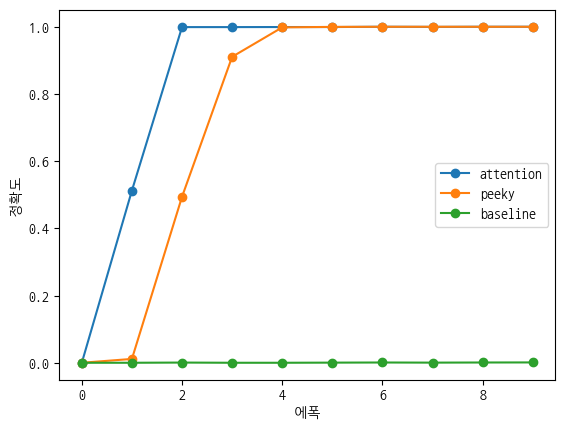

In [43]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# 그래프 그리기
x = np.arange(len(acc_list_attention))
plt.plot(x, acc_list_attention, marker='o', label='attention')
plt.plot(x, acc_list_peeky, marker='o', label='peeky')
plt.plot(x, acc_list_baseline, marker='o', label='baseline')
plt.legend()
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

## 어텐션 시각화

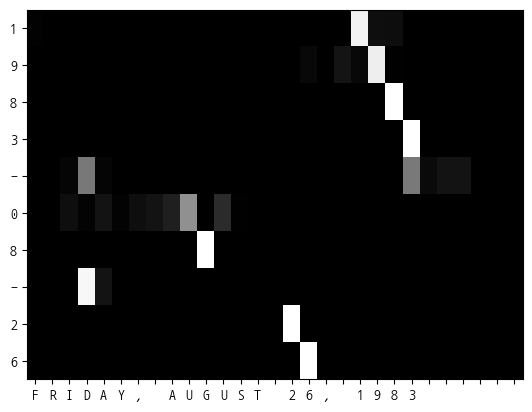

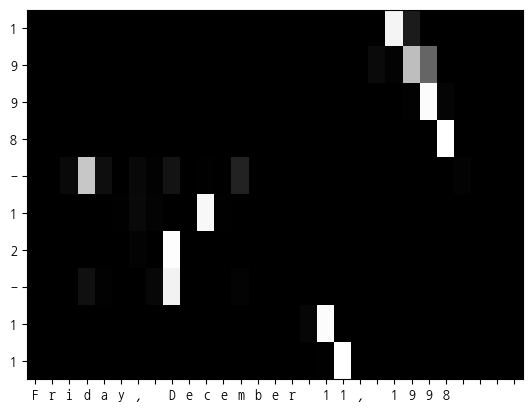

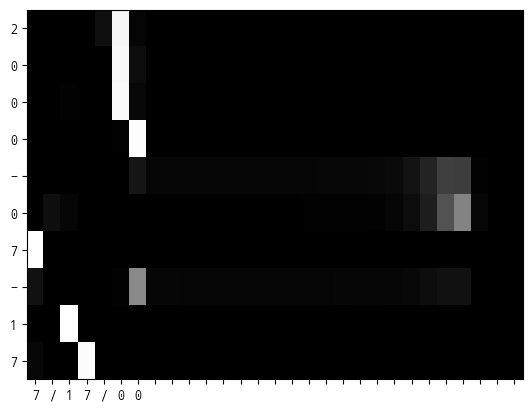

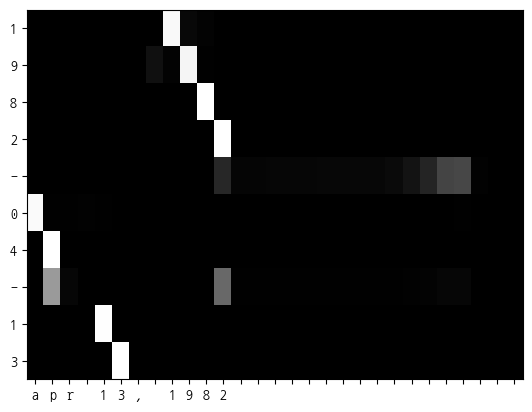

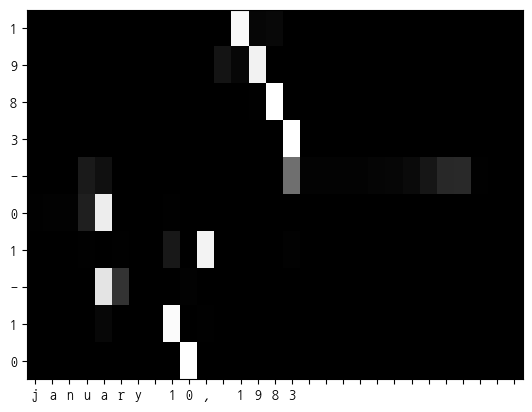

In [44]:

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)